# Projet UTT - MS-EBAM - ARI2 


# Introduction 
### **Edouard Touzé & Geoffrey Harrazi**

Nous allons voir dans ce projet comment classer différentes langue en faisant de la classification binaire à partir des modèle Lasso, Ridge et SVM. Nous allons comparer quatre langues: Le Fraçais, l'anglais, l'allemand et l'espagnol. 

Le code en introduction comprend les imports des modules que nous allons utiliser, le code qui permet de créer les fichier que nous allons utiliser pour importer les données ainsi que les fonctions que nous allons utiliser tout au long du projet afin de faire notre analyse. 

## Import des modules

In [2]:
#Import
import sys, os
import numpy as np
import string
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate 
from sklearn import metrics

#Model
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

#Vizualisation
#%matplotlib notebook 
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import time

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

#PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA


#Timer
import timeit



## Création des fichiers

Cette première cellule vous présente la manière avec laquelle j'ai obtenu les features/caractéristiques à partir des jeux de données de "textes"
Pour obtenir les textes (et les "filtrer") j'ai utiliser le script ./textDatasets/conversion.sh (qui prends, par exemple les fichiers FR_* les concatene, supprime les accents (en gardant les caracteres sans accents) et enfin transforme en minuscules).
J'ai utilisé les livres "open data" de la base du site Guttenberg Project (qui archive énormément de livres en texte, "txt" simples", tombés dans le domaine publique).

In [37]:
import numpy as np
import string
BlockSz=100

# On procede de la même façon pour les differents languages
# Ouverture du fichier texte contenant les caracteres alphabetiques "brutes"
textGERMAN = open('/content/GERMAN')
# Lecture
DE=textGERMAN.read()
textGERMAN.close()
# Calcule du nombre de blocks (arrondi par defaut) de BlockSz caracteres
NbBlock=int(np.floor(len(DE)/BlockSz))
# Creation des tableaux de donnees textuelles et de features
DataDE=[]
FeaDE =[]
# Pour tous les indices de blocks ...
for index in range(NbBlock):
    # Exctraction des donnees texte du block
    DataDE.append(DE[index*BlockSz:(index+1)*BlockSz])
    # Comptage de chacun des caracteres
    countDE=[]
    for letter in string.ascii_lowercase:
        countDE.append(DataDE[index].count(letter))
    # Comptage de toutes les 26**2 paires de caracteres possibles
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countDE.append(DataDE[index].count(letter1+letter2))
    # Une fois le vecteur de décompte obtenu  .... on ajoute ce vecteur (contenant tous les decomptes) au tableaux des features
    FeaDE.append(countDE)

# On procede de la même façon pour les differents languages ....
textFRENCH = open('/content/FRENCH')
FR=textFRENCH.read()
textFRENCH.close()
NbBlock=int(np.floor(len(FR)/BlockSz))
DataFR=[]
FeaFR =[]
for index in range(NbBlock):
    DataFR.append(FR[index*BlockSz:(index+1)*BlockSz])
    countFR=[]
    for letter in string.ascii_lowercase:
        countFR.append(DataFR[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countFR.append(DataFR[index].count(letter1+letter2))
    FeaFR.append(countFR)

# On procede de la même façon pour les differents languages ....
textSPANISH = open('/content/SPANISH')
ES=textSPANISH.read()
textSPANISH.close()
NbBlock=int(np.floor(len(ES)/BlockSz))
DataES=[]
FeaES =[]
for index in range(NbBlock):
    DataES.append(ES[index*BlockSz:(index+1)*BlockSz])
    countES=[]
    for letter in string.ascii_lowercase:
        countES.append(DataES[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countES.append(DataES[index].count(letter1+letter2))
    FeaES.append(countES)

# On procede de la même façon pour les differents languages ....
textENGLISH = open('/content/ENGLISH')
EN=textENGLISH.read()
textENGLISH.close()
NbBlock=int(np.floor(len(EN)/BlockSz))
DataEN=[]
FeaEN =[]
for index in range(NbBlock):
    DataEN.append(EN[index*BlockSz:(index+1)*BlockSz])
    countEN=[]
    for letter in string.ascii_lowercase:
        countEN.append(DataEN[index].count(letter))
    for letter1 in string.ascii_lowercase:
        for letter2 in string.ascii_lowercase:
            countEN.append(DataEN[index].count(letter1+letter2))
    FeaEN.append(countEN)

In [ ]:
np.save('./FeaEN100.npy', FeaEN)
np.save('./FeaFR100.npy', FeaFR)
np.save('./FeaDE100.npy', FeaDE)
np.save('./FeaES100.npy', FeaES)

In [4]:
#Chargement du Dataset avec Block size de 100
FeaEN = np.load('./FeaEN100.npy')
FeaFR = np.load('./FeaFR100.npy')
FeaDE = np.load('./FeaDE100.npy')
FeaES = np.load('./FeaES100.npy')

In [40]:
# Pour plus de "facilier de manipulation" on trasforme les donnes en "matrice numpy" et on affiche la dimension de la base de donnees.
FeaDE = np.array(FeaDE)
print(FeaDE.shape)
FeaDE = np.array(FeaDE)
print(FeaFR.shape)
FeaES = np.array(FeaES)
print(FeaES.shape)
FeaEN = np.array(FeaEN)
print(FeaEN.shape)


(43292, 702)
(41160, 702)
(43218, 702)
(42095, 702)


## Fonctions

Ce sont les fonctions que nous allons utiliser tout au cour du projet. 

La fonction ***feaDatasetsPrep*** permet de fusionner les datasets des langues que nous allons comparer. 

La fonction ***lasso_classifier_result*** est la fonction qui va nous permetre d'établir le seuil pour les résultats de la classification Lasso. Ce seuil est placé à 0 car nous entrainons le modèle sur des données prise entre {-1,1}.

La fonction ***lasso_classifier_target*** est la fonction qui nous permet de transformer la variable target en variables binaires entre {-1,1} pour faire la classification Lasso. 

La fonction ***print_metric*** sera utilisé pour afficher la valeur des métriques utilisé pour comparer les classifieurs. 

La fonction ***mon_Ridge*** est la fonction utilisé pour faire de la classification Ridge. Le découpage du jeu de donnée en jeu d'entrainement et de test est fait à ce niveau.

La fonction ***mon_Lasso*** est utilisé pour faire de la classification Lasso. Nous faisons aussi le découpage du jeu de donnée à ce niveau.

La fonction ***mon_Lasso_nosplit*** sera utilisé pour faire de l'optimisation des hyperparamètres en utilisant la cross-validation. 

La fonction ***mon_SVM*** est la fonction utilisé pour faire de la classification avec SVM. Comme pour les autres fonctions nous avons fait le découpage du jeu de donnée à ce niveau.

La fonction *** Var_name*** qui permet d'afficher le nom de la variable que nous visualisons. 

In [1]:
# On prépare le dataset en fusionnant les Datasets des deux langues souhaitées.
# Dans le premier cas nous utiliserons deux langues latines le Français et l'Espagnol
# Il faut aussi créée la variable cible
# 1 for French et 0 for Spanish  par exemple
def feaDatasetsPrep(X1, X2):
    y_1 = np.ones(X1.shape[0])
    y_2 = np.zeros(X2.shape[0])
    X = np.concatenate((X1, X2), axis=0)
    y = np.concatenate((y_1, y_2), axis=0)
    return X, y



#Fonction pour seuiller les résultats de LASSO et l'utiliser comme classifier à partir du signe de la prédiction
def lasso_classifier_result(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] <= 0:
            y_pred[i] = 0
        else: 
            y_pred[i] = 1
    return y_pred

# Fonction pour que la cible binaire soit comprise entre -1 et 1 pour que l'on fasse une classification sur le signe
def lasso_classifier_target(y_pred):
    Y = np.empty(len(y_pred))
    for i in range(len(y_pred)):
        if y_pred[i] < 0.5:
            Y[i] = -1
        else: 
            Y[i] = 1
    return Y

#Fonctions vous afficher les metriques de nos classifier
def print_metric(nom, y_train, y_test, y_pred_train, y_pred_test):
    print(nom+" Train accuracy: " + str(metrics.accuracy_score(y_train,y_pred_train)*100))
    print(nom+" Test accuracy: " + str(metrics.accuracy_score(y_test,y_pred_test)*100))
    average_precision = metrics.average_precision_score(y_pred_test, y_test)
    print(nom+" Average precision-recall score: {0:0.2f}".format(average_precision))
    print(nom+" Confusion Matrix Train: ")
    print(metrics.confusion_matrix(y_train, y_pred_train, normalize="true"))
    print(nom+" Confusion Matrix Test: ")
    print(metrics.confusion_matrix(y_test, y_pred_test, normalize="true"))
    
    
    

#Ridge
def mon_Ridge(X, y, alpha):
    print("/////// RIDGE alpha="+str(alpha)+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    ridge = RidgeClassifier(alpha=alpha)
    ridge.fit(X_train, y_train)
    stop = timeit.default_timer()
    ridge_y_pred_train = ridge.predict(X_train)
    ridge_y_pred_test = ridge.predict(X_test)
    #ridge_train_score = ridge.score(X_train, y_train)
    #ridge_test_score = ridge.score(X_test, y_test)
    print_metric("Ridge", y_train, y_test, ridge_y_pred_train, ridge_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": ridge, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":ridge_y_pred_train, "y_pred_test":ridge_y_pred_test}

#Lasso
def mon_Lasso(X, y, alpha):
    print("/////// LASSO alpha="+str(alpha)+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    lass = Lasso(alpha=alpha)
    y_train_modifie = lasso_classifier_target(y_train)
    lass.fit(X_train,y_train_modifie)
    stop = timeit.default_timer()
    lass_y_pred_train = lass.predict(X_train)
    lass_y_pred_test = lass.predict(X_test)
    lass_y_pred_train = lasso_classifier_result(lass_y_pred_train)
    lass_y_pred_test = lasso_classifier_result(lass_y_pred_test)    
    print_metric("Lasso", y_train, y_test, lass_y_pred_train, lass_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": lass, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":lass_y_pred_train, "y_pred_test":lass_y_pred_test}
    
#Lasso no test train split
def mon_Lasso_nosplit(X_train, X_test, y_train, y_test, alpha):
    print("/////// LASSO alpha="+str(alpha)+"///////")
    start = timeit.default_timer()
    lass = Lasso(alpha=alpha)
    y_train_modifie = lasso_classifier_target(y_train)
    lass.fit(X_train,y_train_modifie)
    stop = timeit.default_timer()
    lass_y_pred_train = lass.predict(X_train)
    lass_y_pred_test = lass.predict(X_test)
    lass_y_pred_train = lasso_classifier_result(lass_y_pred_train)
    lass_y_pred_test = lasso_classifier_result(lass_y_pred_test)    
    print_metric("Lasso", y_train, y_test, lass_y_pred_train, lass_y_pred_test)
    print('ExecTime: ', stop - start) 
    print("\n\n")
    return {"model": lass, "alpha":alpha, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":lass_y_pred_train, "y_pred_test":lass_y_pred_test}
    


#SVM
def mon_SVM(X, y, kernel, C):
    print("/////// SVM C="+str(C)+" kernel="+kernel+"///////")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
    start = timeit.default_timer()
    svm = SVC(C = C, kernel = kernel)
    svm.fit(X_train, y_train)
    stop = timeit.default_timer()
    svm_y_pred_train = svm.predict(X_train)
    svm_y_pred_test = svm.predict(X_test)
    #svm_train_score = svm.score(X_train, y_train)
    #svm_test_score = svm.score(X_test, y_test)
    print_metric("SVM " + kernel, y_train, y_test, svm_y_pred_train, svm_y_pred_test)
    print('ExecTime: ', stop - start)              
    print("\n\n")
    return {"model": svm, "C":C, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test, "y_pred_train":svm_y_pred_train, "y_pred_test":svm_y_pred_test}
    

def Var_name(n):
  if n <= 26 :
    var = string.ascii_lowercase[n]
  else:
    let1 = int((n-26)/27)
    let2 = n-26-let1*27-1
    var = string.ascii_lowercase[let1]+string.ascii_lowercase[let2]
  
  return var


# Première Question : 
Réaliser une classification binaire en utilisant les méthodes linéaires suivantes: regression "ridge", LASSO et SVM (sans noyau !).
 * Pour ces méthodes vous devez faire une recherche du meilleur paramètre de régularisation ;
 * Vous devrez égalemement selectionner les deux languages de votre choix
 * Dans l'exemple fourni la taille des block de caractère extraits 

## Sélection des langues

Dans cette partie nous allons regarder quelle langue est la plus dur à classifier. Nous les départagerons à partir des performances données sur les sorties du modèle Lasso.

In [42]:
langues = [FeaEN, FeaFR, FeaDE, FeaES]
txt_langues = ["EN", "FR", "DE", "ES"]
for l in range(len(langues)):
    for l2 in range(len(langues)-1,0+l,-1):
        if l != l2 :
          print(txt_langues[l] +"/"+txt_langues[l2])
          X, y = feaDatasetsPrep(langues[l], langues[l2])
          ridge = mon_Lasso(X, y, 1)

EN/ES
/////// LASSO alpha=1///////
Lasso Train accuracy: 95.28508196434508
Lasso Test accuracy: 95.08773176102862
Lasso Average precision-recall score: 0.91
Lasso Confusion Matrix Train: 
[[0.97984427 0.02015573]
 [0.07499556 0.92500444]]
Lasso Confusion Matrix Test: 
[[0.97590531 0.02409469]
 [0.0745702  0.9254298 ]]
ExecTime:  1.5333456510015822



EN/DE
/////// LASSO alpha=1///////
Lasso Train accuracy: 92.01699033368875
Lasso Test accuracy: 92.33444531194549
Lasso Average precision-recall score: 0.87
Lasso Confusion Matrix Train: 
[[0.95139775 0.04860225]
 [0.11195829 0.88804171]]
Lasso Confusion Matrix Test: 
[[0.95042364 0.04957636]
 [0.10448298 0.89551702]]
ExecTime:  1.6208865070002503



EN/FR
/////// LASSO alpha=1///////
Lasso Train accuracy: 95.58623162423808
Lasso Test accuracy: 95.5523202911738
Lasso Average precision-recall score: 0.92
Lasso Confusion Matrix Train: 
[[0.98950427 0.01049573]
 [0.07693397 0.92306603]]
Lasso Confusion Matrix Test: 
[[0.98913761 0.01086239]
 

Nous remarquons que le classifier Lasso à plus de mal à classifier le français et l'espagnol ainsi que l'anglais et l'allemand. Cela peut ce comprendre car les deux couples de langues comparées ont une racine commune et le modèle a donc plus de mal à les différencier que pour les couples de langues ayant des racines différentes.

Dans la suite nous allons donc nous intéresser à un de ces deux couples de langues afin d'avoir une meilleure interprétation de ce que fait le modèle. Nous choisisons d'utiliser le couple de langue FR/ES ayant l'accuracy la plus basse. 


## Classifier Français / Espagnol

Comme expliqué précédemment nous avons choisi d'effectuer nos tests de classification sur les langues Français et Espagol.
C'est deux langues on une racine commune, le latin. Elles devraient donc être plus difficiles à classifier
que deux langues de racine différentes (exemple Français (latin) et Anglais (Germain)).

In [12]:
#On cree notre Dataset
#X features
#y variable cible
X, y = feaDatasetsPrep(FeaFR, FeaES)

In [13]:
#On vérifie la taille
print(X.shape)
print(y.shape)

(84378, 702)
(84378,)


## Ridge vs Lasso vs SVM (sans noyau)

Dans cette partie nous allons regarder les différences entre les trois différents modèles utilisés pour faire de la classification: Le modèle Ridge, Lasso et SVM avec noyau linéaire. Dans un premier temps nous ne ferons pas de validation croisé ni d'optimisation. Puis nous verrons comment la cross-validation et l'optimisation des hyperparamètre impact nos modèles.

### Modèles simple sans cross-validation, ni optimisation. 



#### Classification Ridge
On commence par faire une classification Ridge sur le couple de langue FR/ES.

In [45]:
#Modèle RidgeClassfier de base avec alpha = 1 (default value)
ridge = mon_Ridge(X, y, 1)

/////// RIDGE alpha=1///////
Ridge Train accuracy: 99.93455150089329
Ridge Test accuracy: 99.92817381935716
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Ridge Confusion Matrix Test: 
[[9.99298098e-01 7.01902155e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  2.059057196998765





Nous constatons que le modèle Ridge avec comme valeur par défaut alpha = 1 donne une trés bonne accuracy pour les jeux d'entrainement et de test, il n'y a donc pas d'overfitting. Les matrices de confusions pour ces deux jeux de données donnent aussi de trés bon résultats ce qui concorde avec les trés bonnes valeurs d'accuracy. 

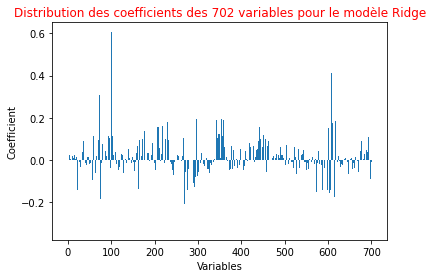

La variables ayant le coefficient max 0.604894 est 'cu', c'est la variable n° 101 


In [46]:
plt.bar(range(len(ridge["model"].coef_[0])), ridge["model"].coef_[0])
plt.title(label="Distribution des coefficients des 702 variables pour le modèle Ridge",
          fontsize = 12,
          color = "Red")
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.show()

coef_max = max(ridge["model"].coef_[0])
var_max = int(np.where(ridge["model"].coef_[0]==coef_max)[0])
print("La variables ayant le coefficient max %f est '%s', c'est la variable n° %d "
       %(coef_max,Var_name(var_max),var_max))

Ce graphe affiche les coefficients des 702 différentes variables utilisées par le modèle pour réaliser la classification Ridge. Pour la comparaison du français avec l'espagnol il semblerait que le modèle ne privilégie pas une variable plus qu'une autre. Cependant nous remarquons que la variables "CU" est celle sur laquelle le modèle s'appuie le plus pour distinguer les deux langues. Le vecteur de projection, qui est le vecteur orthogonal à l'hyper-plan séparateur des classes, est donc le vecteur $U$ tel que :

>> $ U =  \sum_{i=1}^{n} \theta_{i} X_i $

ou $\theta_i$ sont les coefficient du modèle associé à chaques variables $X_i$ et $n$ le nombre de variables qui vaut ici 702. 

#### Classification Lasso
Nous allons analyser plus en détails la classification Lasso précédement réalisé sur le couple de langue FR/ES.

In [47]:
#Modèle Lasso de base avec alpha = 1 (default value)
lasso = mon_Lasso(X,y,1)

/////// LASSO alpha=1///////
Lasso Train accuracy: 91.13438168857128
Lasso Test accuracy: 90.92476207577663
Lasso Average precision-recall score: 0.88
Lasso Confusion Matrix Train: 
[[0.89831211 0.10168789]
 [0.07495828 0.92504172]]
Lasso Confusion Matrix Test: 
[[0.89485506 0.10514494]
 [0.07567289 0.92432711]]
ExecTime:  1.3173440140017192





Nous pouvons voir que la classification Lasso pour une valeur de alpha = 1 est néttement moin bon que le modèle Ridge. En effet on passe d'une accuracy de 99% à 91% pour le jeu d'entrainement et de 90% pour le jeu de test. On remarque cependant que ces deux valeurs reste proche et nous pouvons en conclure qu'il n'y a pas d'overfitting. Le modèle est moin précis mais met moin de temps. 

In [48]:
# on regarde les coefficients non nuls 
print("Nombre de coefficients non-nuls:", np.count_nonzero(lasso["model"].coef_))
non_zero_val = np.where(lasso["model"].coef_ != 0)[0]
for i in range(len(non_zero_val)):
 print("Le coefficient de la variable",Var_name(non_zero_val[i])," n°:",non_zero_val[i],"vaut",lasso["model"].coef_[non_zero_val[i]])


Nombre de coefficients non-nuls: 3
Le coefficient de la variable a  n°: 0 vaut -0.05981159351213096
Le coefficient de la variable o  n°: 14 vaut -0.10040566153921375
Le coefficient de la variable t  n°: 19 vaut 3.583312071386435e-05


Le modèle semble n'utiliser que ces trois variables pour classer les langues. On constate que la variable sur laquelle le modèle se calque le plus pour différencier les langues française et espagnol est la variables "o". Cela pourrait expliquer la plus faible accuracy du modèle par rapport au modèle Ridge ainsi que sa rapidité d'éxécution. Cependant il est difficile d'expliquer exactement pourquoi le modèle choisit de se fixer sur ces variables plus que d'autre. Le vecteur de projection obtenu peut donc simplement s'écrire : 

$ U = \theta_0 X_0 + \theta_14 X_{14} + \theta_{19} X_{19}$

$ => U = - 0.06 X_0 - 0.1 X_{14} + 3.6e^{-05} X_{19}$


#### Classification SVM

Nous allons maintenant passer au dernier classifier, la SVM.

In [49]:
#Modèle SVM de base avec C = 1 (default value)
svm = mon_SVM(X, y, "linear", C=1)

/////// SVM C=1 kernel=linear///////
SVM linear Train accuracy: 100.0
SVM linear Test accuracy: 99.91021727419644
SVM linear Average precision-recall score: 1.00
SVM linear Confusion Matrix Train: 
[[1. 0.]
 [0. 1.]]
SVM linear Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [1.02956317e-03 9.98970437e-01]]
ExecTime:  29.83189271900119





Nous obtenons un score d'accuracy encore meilleur que pour la classification Lasso et Ridge cependant le modèle prend beaucoup plus de temps à tourner $\approx$ 30 sec pour la SVM contre 1 à 2 sec pour Lasso et Ridge. 

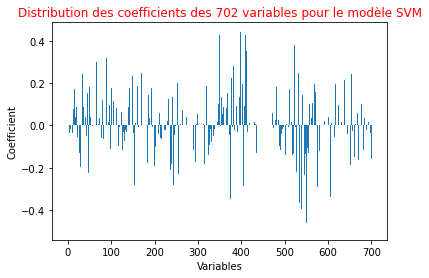

La variables ayant le coefficient max 0.440145 est 'nu', c'est la variable n° 398 


In [50]:
plt.bar(range(len(svm["model"].coef_[0])), svm["model"].coef_[0])
plt.title(label="Distribution des coefficients des 702 variables pour le modèle SVM",
          fontsize = 12,
          color = "Red")
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.show()

coef_max = max(svm["model"].coef_[0])
var_max = int(np.where(svm["model"].coef_[0]==coef_max)[0])
print("La variables ayant le coefficient max %f est '%s', c'est la variable n° %d "
       %(coef_max,Var_name(var_max),var_max))

Comme pour le modèle Ridge la classification SVM prend en compte quasiment toutes les variables afin de distinguer les deux langues. La répartition des coéfficient est cependant plus "lissé" que par rapport au modèle Ridge. Le vecteur de projection est, comme pour le modèle ridge, la somme des produits de coéfficient avec la valeur des variables.

>> $ U =  \sum_{i=1}^{n} \theta_{i} X_i $

Nous avons ici créée 3 modèles différent sans optimisation pour notre problèmes de classification des langues FR/ES. Le modèle lasso étant le moins performant mais le plus rapide. Comme nous l'avons dit cela pourrait provenir du fait que le modèle ne prend en compte que trés peu de variable pour réaliser la classification.

Les modèles RidgeClassifier et SVC (SVM) avec noyau linéair on des résultats presque parfaits.
Néanmoins la SVM a un temps de calcul trop élevé avec des résultats compratable à Ridge. 

Nous concidérons qu'il est plus interessant de se concentrer sur l'optimisation de Lasso pour essayer d'en tirer de meilleur résultat. 

### Optimisation de LASSO

Nous allons entrainer plusieurs modèle lasso avec des valeurs de 10 alpha croissantes pour observé l'impact de la régularization sur la modélistaion de ce problème. 

On commence par définir les alphas sur lesquels nous allons entrainer notre modèle. 

In [10]:
alphas = np.logspace(-10, 0.5, 10)
print(len(alphas))
alphas

10


array([1.00000000e-10, 1.46779927e-09, 2.15443469e-08, 3.16227766e-07,
       4.64158883e-06, 6.81292069e-05, 1.00000000e-03, 1.46779927e-02,
       2.15443469e-01, 3.16227766e+00])

Ensuite nous lanssons l'entrainement de nos modèles. Cela se résume simplement par une boucle. 

In [14]:
tab_lasso=[]
for i in range(len(alphas)):
    tab_lasso.append(mon_Lasso(X, y, alphas[i]))

/////// LASSO alpha=1e-10///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5877713538778, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  67.90277028200217



/////// LASSO alpha=1.4677992676220676e-09///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5855345266614, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  65.5309287300006



/////// LASSO alpha=2.1544346900318866e-08///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.5525425156618, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  61.098799666997365



/////// LASSO alpha=3.162277660168379e-07///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732.0352711060682, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92458251032501
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  60.70969256600074



/////// LASSO alpha=4.641588833612782e-06///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1719.2451328655982, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.93455150089329
Lasso Test accuracy: 99.92817381935716
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Lasso Confusion Matrix Test: 
[[9.99298098e-01 7.01902155e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  60.97307723800259



/////// LASSO alpha=6.812920690579622e-05///////


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1310.9915705395356, tolerance: 5.649788279411991
  positive)


Lasso Train accuracy: 99.91863159570516
Lasso Test accuracy: 99.93176512838929
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99413206e-01 5.86793690e-04]
 [1.05217328e-03 9.98947827e-01]]
Lasso Confusion Matrix Test: 
[[9.99368288e-01 6.31711939e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  58.04906514200047



/////// LASSO alpha=0.001///////
Lasso Train accuracy: 99.90094281216281
Lasso Test accuracy: 99.93535643742145
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[9.99378689e-01 6.21310966e-04]
 [1.37870982e-03 9.98621290e-01]]
Lasso Confusion Matrix Test: 
[[9.99508668e-01 4.91331508e-04]
 [8.08942492e-04 9.99191058e-01]]
ExecTime:  19.111173692999728



/////// LASSO alpha=0.014677992676220735///////
Lasso Train accuracy: 99.64622432915289
Lasso Test accuracy: 99.66241695097862
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[0.99489144 0.00510856]
 [0.00188666 0.99811334]]
Lasso Confusion 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Nous allons créer deux listes afin de récuperer les scores d'accuracy de nos modèle précédemment entrainé sur les différents alpha. 

In [54]:
test_acc=[]
train_acc=[]
for l in tab_lasso:
    test_acc.append(metrics.accuracy_score(l['y_test'],l['y_pred_test'])*100)
    train_acc.append(metrics.accuracy_score(l['y_train'],l['y_pred_train'])*100)

Nous réalisons un graphe représentant la valeur des scores d'accuracy en fonction de nos alphas.

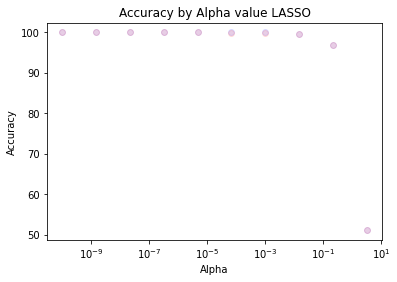

In [55]:
plt.figure(0)
plt.plot(alphas, test_acc, 'bo', alpha =0.1)
plt.plot(alphas, train_acc, 'ro', alpha =0.1)
plt.title("Accuracy by Alpha value LASSO")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.show()

On peut observer que plus l'on régularise LASSO c'est à dire que plus l'on augmente alpha, moins le modèle est performant. D'ailleurs nous pouvons voir que pour la dernière valeur de alpha = 3.16 le modèle n'a pas réussi à classer nos deux langue. 

De plus même avec un alpha très proche de zero le modèle ne montre pas de signe d'overfitting des données. 

Néanmoins plus alpha est faible plus le temps de calcul est long et sickit affiche des warning du à la faible valeur d'alpha qui donne des calcules de petites valeurs très long. 

A partir de la 7eme valeurs d'alpha testé on passe d'environ 60 secondes d'éxecution à 15 secondes pour une accuracy toujours très bonne proche de 99%. C'est donc l'un des meilleurs modèles en terme de ratio performance/temps. 

On choisira le modèle tel que alpha=0.015 celui-ci étant le modèle qui a pour nous le meilleure ratio performance / temp. 

### Cross-validation pour LASSO

Dans cette partie nous allons voir la cross-validation qui consiste à subdivisé notre jeu de donnée en $k$ sous-ensembles de jeux de données d'entrainement et de test puis d'entrainer le modèle sur ces différents jeux. Ensuite il suffit de faire la moyenne des métriques obtenue pour chaque sous-enssemnles de jeux de données afin d'obtenir une métrique nous permettant d'analyser notre modèle. Cette méthode est essentiellement utilisé pour évité l'overfitting des modèles. Nous verons comment celle-ci impacte le notre. 

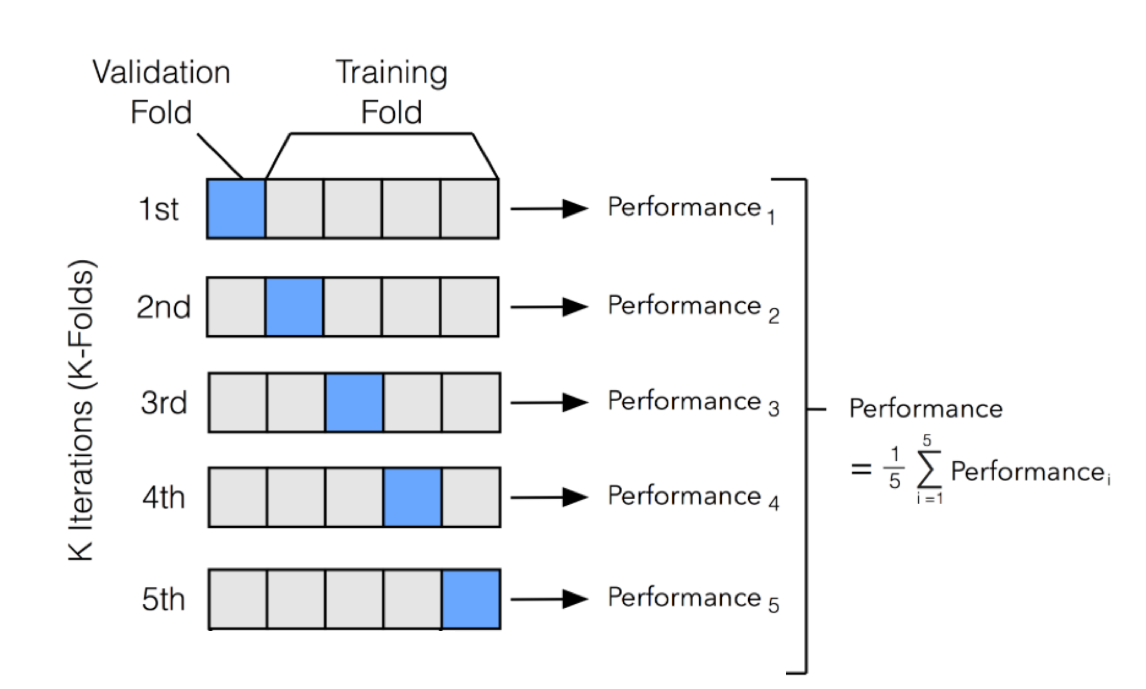

Dans un premier temps nous créons une fonction qui permet de faire cette cross-validation. Nous sauvegardons les valeurs des jeux de données au cas ou nous souhaitons les réutiliser plus tard. 

In [6]:
#Dataset FR et EN

X_fres, y_fres = feaDatasetsPrep(FeaFR, FeaES)

# Fonction qui permet de réaliser la cross-validation. 
def Kfold_Lasso(X, y, nb_kfold, alpha_param):
    # prepare cross validation
    kfold = KFold(nb_kfold,shuffle=True)
    # enumerate splits
    test_acc = []
    train_acc = []
    test_confmatric = []
    train_confmatric = []
    tab_lasso = []
    for train_index, test_index in kfold.split(X, y):        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]        
        tab_lasso.append(mon_Lasso_nosplit(X_train, X_test, y_train, y_test, alpha_param))        
    return tab_lasso


On fait l'entrainement de notre modèle avec la cross-validation, on choisit de diviser le jeu de données en 10 sous-ensemble. Cela veut dire que pour chaque entrainement de notre modèle, neuf seront utilisé pour l'entrainement et un pour le test.

In [7]:
tab_lasso_kfold = Kfold_Lasso(X_fres, y_fres, 10, 0.015)

/////// LASSO alpha=0.015///////
Lasso Train accuracy: 99.66684224387674
Lasso Test accuracy: 99.5141028679782
Lasso Average precision-recall score: 0.99
Lasso Confusion Matrix Train: 
[[0.99518785 0.00481215]
 [0.00177994 0.99822006]]
Lasso Confusion Matrix Test: 
[[0.99311611 0.00688389]
 [0.00269608 0.99730392]]
ExecTime:  4.823572702000092



/////// LASSO alpha=0.015///////
Lasso Train accuracy: 99.66420858572558
Lasso Test accuracy: 99.63261436359326
Lasso Average precision-recall score: 0.99
Lasso Confusion Matrix Train: 
[[0.99511254 0.00488746]
 [0.00175368 0.99824632]]
Lasso Confusion Matrix Test: 
[[0.99562514 0.00437486]
 [0.0029304  0.9970696 ]]
ExecTime:  5.07254366000052



/////// LASSO alpha=0.015///////
Lasso Train accuracy: 99.63787200421386
Lasso Test accuracy: 99.78667930789287
Lasso Average precision-recall score: 1.00
Lasso Confusion Matrix Train: 
[[0.9948084  0.0051916 ]
 [0.00197132 0.99802868]]
Lasso Confusion Matrix Test: 
[[9.96750986e-01 3.24901369e-03]
 [

On fait la moyennne des scores d'accuracy obtenus sur à partir de la cross-validation.

In [8]:
test_acc=[]
train_acc=[]
for l in tab_lasso_kfold:
    test_acc.append(metrics.accuracy_score(l['y_test'],l['y_pred_test'])*100)
    train_acc.append(metrics.accuracy_score(l['y_train'],l['y_pred_train'])*100)
print("///////////////Kfold MOYEN////////////////////")
print("Lasso Train accuracy: " + str(np.mean(train_acc)))
print("Lasso Test accuracy: " + str(np.mean(test_acc)))    

///////////////Kfold MOYEN////////////////////
Lasso Train accuracy: 99.65499170989501
Lasso Test accuracy: 99.65038434554869


On constate des matrices de confusion et des scores d'accuracy très proches, nous pouvons donc conclure qu'il ny a pas d'overfitting avec ce modèle. Surtout avec une cross-validaiton de 10. Nous pouvons donc valider notre modèle lasso précédement trouvé avec cette valeur de alpha = 0.015.

### Hyperparameter Tuning pour Ridge

Nous allons voir une autre façons d'optimiser un modèle. Cela consiste à réaliser les mêmes étapes que nous avons vu précédemment. Cette fois-ci nous le faisons pour le modèle Ridge. Nous allons rechercher les meilleurs hyperparamètres pour le modèle avec de la cross-validation. Pour cela nous utilisons deux méthodes:
> le **GridSearch** de Sklearn qui prend en entrée le model choisis, un dictionnaire des différents hyperparamètres, le nombre de sous-ensemble de la cross-validation.

> le **RandomSearch** de Sklearn qui prend les même paramètres d'entrée que GridSearch mais qui va prendre aléatoirement les valeurs du paramètre de régularisation alpha dans celle qu'on lui a fournit. 

In [19]:
alphas = np.logspace(-10, 1, 20)
hyperparameters = dict(alpha = alphas)
model = RidgeClassifier()
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X,y)
print("Best Alpha", best_model.best_estimator_.get_params()["alpha"])
#Ici le résultat indique un Alpha égale à 1e-10

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.26371e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.25132e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.58716e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13552e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.11497e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

Best Alpha 1e-10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.01339e-17): result may not be accurate.
  overwrite_a=True).T


In [18]:
alphas = np.logspace(-10, 1, 20)
hyperparameters = dict(alpha = alphas)
rsearch = RandomizedSearchCV(model, hyperparameters, n_iter=10, random_state=41)
rsearch.fit(X, y)
print(rsearch.best_params_)
#En effet on tombe sur la même valeurs de alpha = 1e-10

{'alpha': 6.158482110660267e-05}


Nos deux technique de recherche d'Hyperparamètre pour Ridge nous montre la meme conclusion qu'avec LASSO. 
Le modèle Ridge est déjà très performant sur ce problème et les meilleurs alphas selectionné nous montre des valeurs très proche de zero. Il est donc pas nécéssaire de régularisé ce modèle. Des valeurs de alpha très proches de zero donne de très bon résultat sans overfitting. 

In [ ]:
#Clear variable:
ridge = 0
lass = 0
lasso = 0
svm = 0
tab_lasso = 0
tab_lasso_kfold = 0

# Deuxième Question:
Réaliser une classification binaire avec l'une des méthodes linéaire précédent en utilisant la réduction de dimension (ACP par exemple, ou une autre méthode)


## Réduction de dimension

Pour la réduction de dimension de nos données nous allons utiliser la méthode de l'analyse en composantes principales. Cette analyse va nous permetre de réduire le nombre de variables de notre jeu d'entrainement utilisé afin de diminuer le temps de calcul de la classification. Les variables créés sont une combinaison linéaire de nos ancienne variables. Nous faisons une première ACP sur 100 composant dans un premier temps afin d'identifier les variables les plus importantes que nous devrons garder dans la suite.  

In [ ]:
#PCA avec une réduction à 100 n_component
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X)   
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance) #Ici on peut voir la variance "expliqué" par chaque variable réduite


[0.16030628 0.0663639  0.05317713 0.05123404 0.03960218 0.03704974
 0.03297275 0.03062289 0.02566717 0.02307861 0.0197429  0.01887309
 0.01380858 0.01240486 0.01046423 0.00985208 0.00898408 0.00864658
 0.00782963 0.00769488 0.0075722  0.00718166 0.00670741 0.00655848
 0.00617729 0.0059141  0.00578946 0.00563653 0.0055292  0.00533833
 0.00524912 0.00508698 0.00488919 0.00477237 0.00459624 0.00436974
 0.00410742 0.00408146 0.00405914 0.00396085 0.00391737 0.00375907
 0.00370578 0.00360951 0.00355543 0.00347555 0.00345828 0.00337733
 0.00330026 0.00326353 0.00321195 0.00313749 0.00308166 0.00303064
 0.00300895 0.00294371 0.00285277 0.00277869 0.00271659 0.00267072
 0.00263523 0.00261096 0.00257236 0.00249867 0.00248775 0.00245963
 0.00242037 0.00238539 0.00235772 0.00232408 0.00226104 0.00222627
 0.00221528 0.002159   0.0021326  0.0021131  0.00208224 0.00203554
 0.00201577 0.00195444 0.00192561 0.00191436 0.00189404 0.00186736
 0.00184276 0.00182409 0.0017627  0.00174186 0.00168719 0.0016

La PCA est une méthode qui permet de créer de nouvelles variables a partir d'une combinaison linéaire de nos anciennes variables. Ces nouvelles variables sont créer de manière à expliquer le plus la variance de notre jeux de donnée initial lorsque l'on projettes ces données sur notre nouvel ensemble de variables. Cela permet d'obtenir des variables linéairement indépendante. La méthode 

```
pca.explained_variance_ratio_
```
permet de donner le pourcentage de variance expliqué par chaque nouvelle variables créé de notre ancien jeu de données. 


<IPython.core.display.Javascript object>


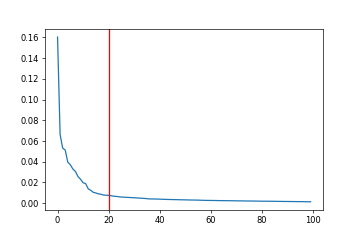

In [ ]:
plt.figure(0)
plt.plot(range(len(explained_variance)), explained_variance)
plt.axvline(x=20, color="red")
plt.show()

On utilise le Critère du coude afin de déterminer le nombre de variables min à utiliser. On observe un décrochement suivi d'une décroisance régulière. A partir de ce décrochement il n'est pas nécéssaire de garder les variables d'après.

Ce décrochement est observé autour de 20. Dans la suite nous ferons donc une ACP pour ne garder que 20 variables. 

In [21]:
#On tente une PCA avec 20
pca = PCA(n_components = 20)
X_pca = pca.fit_transform(X) 
#X_test = pca.transform(X_test)  
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[0.16030628 0.0663639  0.05317713 0.05123404 0.03960218 0.03704974
 0.03297275 0.03062289 0.02566717 0.02307861 0.0197429  0.01887309
 0.01380856 0.01240481 0.01046408 0.00985192 0.00898213 0.00864569
 0.00782757 0.00769066]


In [22]:
np.sum(explained_variance)

0.6383661061225285

Avec ces 20 PCA on peut expliqué environ 64% de la variance de notre jeu de donnée. Maintenant nous allons voir l'impact de cette perte pour le modèle Lasso.

In [23]:
# ici pour le Lasso le modéle avait été réalisé optisé sur une autre machine 
# mais la valeur du alpha utilisé ici étant inférieur à celle précédemment utilisé
# nous avons 
alpha = 0.015
lasso = mon_Lasso(X_pca, y, alpha)

/////// LASSO alpha=0.015///////
Lasso Train accuracy: 99.48879415562591
Lasso Test accuracy: 99.52594720775723
Lasso Average precision-recall score: 0.99
Lasso Confusion Matrix Train: 
[[0.99299299 0.00700701]
 [0.00312024 0.99687976]]
Lasso Confusion Matrix Test: 
[[0.99319155 0.00680845]
 [0.00257391 0.99742609]]
ExecTime:  0.06194072400103323





Nous pouvons voir que le modèle Lasso présente toujours de trés bonne performances et nous avons divisé le temps d'exécution par six. 

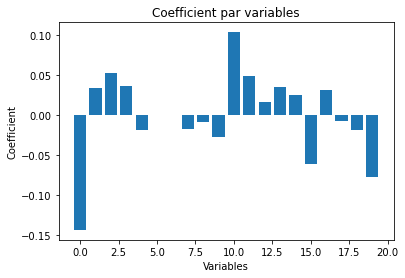

In [25]:
#On peut observé l'importance de la première features
plt.bar(range(len(lasso["model"].coef_)), lasso["model"].coef_)
plt.title("Coefficient par variables")
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.show()

Ce graphique permet de voir l'importance de chaque nouvelles variables dans la prédiction réalisé par le modèle Lasso à partir des jeux de données avec les nouvelles variables. Nous pouvons voir que la première variables (celle qui expliquer 16% de la variance de notre ancien jeux de donnée) est la variable la plus prise en compte par notre modèle. C'est donc la variable la plus pertinentes i.e c'elle qui permet de mieux faire la différence entre les deux langues. 

Dans la suite nous représentons le jeux de données en fonction des deux et trois premières variables issue de l'ACP respectivement par des nuages de point sur des graphes en 2D et en 3D. Les jeux de données sont classé en fonction de leurs langues. 

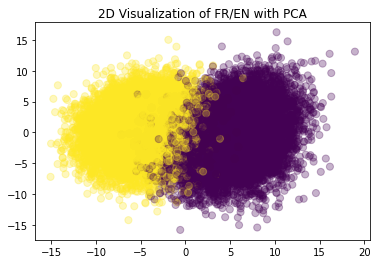

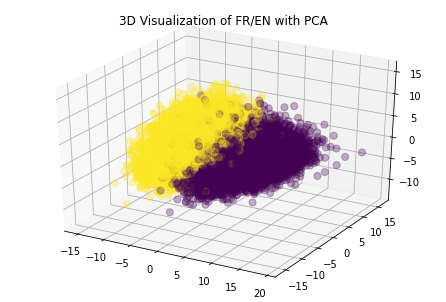

In [33]:
Xldr = lasso['X_test'][:,0]
Yldr = lasso['X_test'][:,1]
Zldr = lasso['X_test'][:,2]
n = lasso['X_test'].shape[0]
d = lasso['X_test'].shape[1]
Cgt = lasso['y_test']


# 2D Plot
plt.figure(0)
size_vertex_plot = 50
plt.scatter(Xldr, Yldr, s=size_vertex_plot*np.ones(n), c=Cgt,alpha=0.3)
plt.title('2D Visualization of FR/EN with PCA') 
plt.show()

# 3D Plot
fig = pylab.figure(2)
ax = Axes3D(fig)
size_vertex_plot = 50
ax.scatter(Xldr, Yldr, Zldr, s=size_vertex_plot*np.ones(n), c=Cgt, alpha=0.3)
plt.title('3D Visualization of FR/EN with PCA') 
pyplot.show() 



Sur les deux graphes ci-dessus nous pouvons voir que les données sont bien séparé en deux nuages de point, le jaune représentant la langue française et le violet l'espagnol. Nous pouvons voir que l'ACP à permit de séparé les deux langues en deux nuages de point distinct. C'est en réalisant cette opération que nous améliorons les performances de notre modèle. 

Regardons d'un peu plus prés les valeurs prédite par le modèle sur un graphe en 2D en ne prenant que la première variable et sur un graphe en 3D en prenant les deux premières variables.

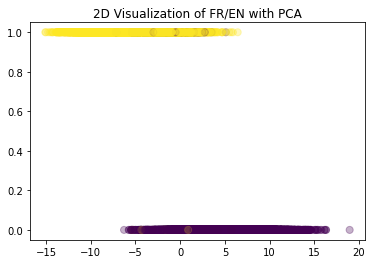

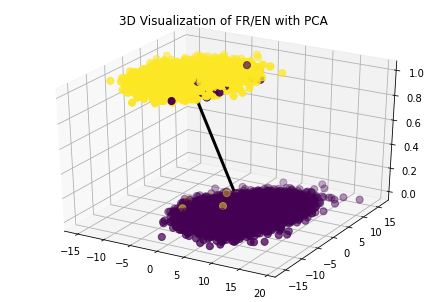

In [27]:
X_moyen_0 = Xldr[lasso['y_pred_test'] == 0].mean()
Y_moyen_0 = Yldr[lasso['y_pred_test'] == 0].mean()
X_moyen_1 = Xldr[lasso['y_pred_test'] == 1].mean()
Y_moyen_1 = Yldr[lasso['y_pred_test'] == 0].mean()

plt.figure(0)
size_vertex_plot = 50
plt.scatter(Xldr, lasso['y_pred_test'], s=size_vertex_plot*np.ones(n), c=Cgt, alpha=0.3)
plt.title('2D Visualization of FR/EN with PCA') 
plt.show()

fig = pylab.figure(2)
ax = Axes3D(fig)
size_vertex_plot = 50
ax.scatter(Xldr, Yldr, lasso['y_pred_test'], s=size_vertex_plot*np.ones(n), c=Cgt)
ax.plot([X_moyen_0,X_moyen_1],[Y_moyen_0,Y_moyen_1],[0,1], lw = 3, color= "Black")
plt.title('3D Visualization of FR/EN with PCA') 
pyplot.show()

Nous avons projeté notre jeu de données modifié par l'ACP sur les prédiction faites par notre modèle. Nous distinguons encore mieux la scission entre les deux groupes de données appartenant d'une part à la langue française et de l'autre à la langue espagnol. La regression linéraire revient à chercher la droite noir sur notre graphe qui est orthogonal au plan séparateur des classes. L'ACP nous a donc permis de créer un nouveau jeu de données ayant des variables permettant de mieux distinguer l'appartenance des données à une classe ce qui permet d'accélérer l'apprentissage de notre modèle. 

# Troisième Question:
* Modifier la taille des données extraites (BlockSz) afin de trouver une taille à partir de la quelle un taux d'erreur de l'ordre de 10% est observée
* Avec cette taille de block comparer les méthodes de classification précédentes (avec et sans réduction de dimentionalité)

Nous allons modifier la taille des données extraites afin de voir son impact sur la performance de nos modèle. Nous réalisons ces test pour des tailles de block de 20, 50, 100 et 150. Dans un premier temps nous réalisons les tests sans faire d'ACP puis nous réalisons les même tests en faisant une ACP ne prenant en compte que 2 variables. Ces tests sont réalisé pour les modèles Lasso et Ridge.   

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks SANS PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    alpha = 3.35981829e-03
    lasso = mon_Lasso(X, y, alpha)
    X, y = 0, 0 
    lasso = 0


///////////20 Blocks SANS PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 93.28823920641884
Lasso Test accuracy: 93.22109376122276
Lasso Average precision-recall score: 0.90
Lasso Confusion Matrix Train: 
[[0.93493562 0.06506438]
 [0.06927768 0.93072232]]
Lasso Confusion Matrix Test: 
[[0.93438523 0.06561477]
 [0.07006304 0.92993696]]
ExecTime:  9.418564500000002



///////////50 Blocks SANS PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 98.87765661068217
Lasso Test accuracy: 98.9621116897109
Lasso Average precision-recall score: 0.98
Lasso Confusion Matrix Train: 
[[0.98723073 0.01276927]
 [0.00960703 0.99039297]]
Lasso Confusion Matrix Test: 
[[0.98868755 0.01131245]
 [0.00939037 0.99060963]]
ExecTime:  3.9153101000001698



///////////100 Blocks SANS PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 99.80719225938832
Lasso Test accuracy: 99.85634763871431
Lasso Average precisio

Pour le modèle sans ACP nous pouvons constater une diminution de l'accuracy lorsque l'on diminue la taille de block. Le fait de diminuer la taille des block va accroitre le nombre d'échantillons sur lequels nous entrainons le modèle mais ceux-ci comprendrons moins d'informations i.e les patterns qui devraient se retrouver dans une langue seront alors plus difficiles à identifier pour le modèle. 

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks AVEC 2 composantes PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    pca = PCA(n_components = 2)    
    X_pca = pca.fit_transform(X)   
    alpha = 3.35981829e-03
    lasso = mon_Lasso(X_pca, y, alpha)
    X, y = 0, 0
    X_pca = 0
    lasso = 0

///////////20 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 68.31300324055076
Lasso Test accuracy: 68.43549337049114
Lasso Average precision-recall score: 0.60
Lasso Confusion Matrix Train: 
[[0.70504009 0.29495991]
 [0.33992015 0.66007985]]
Lasso Confusion Matrix Test: 
[[0.70632122 0.29367878]
 [0.33861843 0.66138157]]
ExecTime:  0.00920670000004975



///////////50 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 84.88949030221019
Lasso Test accuracy: 85.12300233435087
Lasso Average precision-recall score: 0.80
Lasso Confusion Matrix Train: 
[[0.84104161 0.15895839]
 [0.14289333 0.85710667]]
Lasso Confusion Matrix Test: 
[[0.84298733 0.15701267]
 [0.14004215 0.85995785]]
ExecTime:  0.004707300000063697



///////////100 Blocks AVEC 2 composantes PCA ////////////////
/////// LASSO alpha=0.00335981829///////
Lasso Train accuracy: 95.24879274052324
Lasso Test acc

Le fait d'utiliser l'ACP nous permet d'accélérer le temps d'exécution mais nous entrainons le modèle que sur deux variables qui n'explique que 20% du jeu de donnée. Nous perdons donc beaucoup d'information lorsque nous réduisons en plus la taille de block. Cela explique le faible score d'accuracy pour le modèle pour une taille de block de 20.

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks SANS PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    alpha = 1e-10
    lasso = mon_Ridge(X, y, alpha)
    X, y = 0, 0 
    lasso = 0


///////////20 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 96.00485375068986
Ridge Test accuracy: 96.0266042262221
Ridge Average precision-recall score: 0.94
Ridge Confusion Matrix Train: 
[[0.96329648 0.03670352]
 [0.04336842 0.95663158]]
Ridge Confusion Matrix Test: 
[[0.96419991 0.03580009]
 [0.04384818 0.95615182]]
ExecTime:  27.0450557



///////////50 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21821e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge Train accuracy: 99.53921126411774
Ridge Test accuracy: 99.50619500808044
Ridge Average precision-recall score: 0.99
Ridge Confusion Matrix Train: 
[[0.99550134 0.00449866]
 [0.0047221  0.9952779 ]]
Ridge Confusion Matrix Test: 
[[0.99493733 0.00506267]
 [0.00480609 0.99519391]]
ExecTime:  2.013861300000002



///////////100 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 99.93455150089329
Ridge Test accuracy: 99.92458251032501
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99482241e-01 5.17759138e-04]
 [7.98200421e-04 9.99201800e-01]]
Ridge Confusion Matrix Test: 
[[9.99227908e-01 7.72092370e-04]
 [7.35402265e-04 9.99264598e-01]]
ExecTime:  4.721075800000001



///////////150 Blocks SANS PCA ////////////////
/////// RIDGE alpha=1e-10///////


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.42635e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge Train accuracy: 99.981426448737
Ridge Test accuracy: 99.97845291962939
Ridge Average precision-recall score: 1.00
Ridge Confusion Matrix Train: 
[[9.99896635e-01 1.03364515e-04]
 [2.72643001e-04 9.99727357e-01]]
Ridge Confusion Matrix Test: 
[[1.00000000e+00 0.00000000e+00]
 [4.39512142e-04 9.99560488e-01]]
ExecTime:  0.6283814000000021





Comme nous avons pu le constater avant le modèle Ridge à de meilleur performance que le modèle Lasso cependant celui-ci perd aussi en performance lorsque la taille des blocks diminue. 

In [ ]:
load=["20", "50", "100", "150"]
for i in range(len(load)):
    print("///////////"+load[i]+" Blocks AVEC 2 composantes PCA ////////////////")
    #FeaEN = np.load("./FeaEN"+load[i]+'.npy')
    FeaFR = np.load("./FeaFR"+load[i]+'.npy')
    #FeaDE = np.load("./FeaDE"+load[i]+'.npy')
    FeaES = np.load("./FeaES"+load[i]+'.npy')
    X, y = feaDatasetsPrep(FeaFR, FeaES)
    FeaFR=0
    FeaES=0
    pca = PCA(n_components = 2)    
    X_pca = pca.fit_transform(X)   
    alpha = 1e-10
    lasso = mon_Ridge(X_pca, y, alpha)
    X, y = 0, 0
    X_pca = 0
    lasso = 0

///////////20 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 68.31689473162862
Ridge Test accuracy: 68.43836639708101
Ridge Average precision-recall score: 0.60
Ridge Confusion Matrix Train: 
[[0.70474337 0.29525663]
 [0.33952813 0.66047187]]
Ridge Confusion Matrix Test: 
[[0.70604021 0.29395979]
 [0.33826576 0.66173424]]
ExecTime:  0.10255719999999258



///////////50 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 84.90098790982337
Ridge Test accuracy: 85.12300233435087
Ridge Average precision-recall score: 0.80
Ridge Confusion Matrix Train: 
[[0.84102431 0.15897569]
 [0.14264003 0.85735997]]
Ridge Confusion Matrix Test: 
[[0.84302224 0.15697776]
 [0.14007912 0.85992088]]
ExecTime:  0.03647629999998969



///////////100 Blocks AVEC 2 composantes PCA ////////////////
/////// RIDGE alpha=1e-10///////
Ridge Train accuracy: 95.26825040241982
Ridge Test accuracy: 95.15532411564016


Nous n'avons pas réussis à avoir 10% d'érreurs même avec les modèles les moins performant et pour des langues les plus difficilement différenciables. Même en déscendant à 20 block nous obtenons une 7% d'erreurs pour Lasso et 4% pour Ridge sans ACP. Le fait de n'utiliser que deux composantes avec l'ACP diminue grandement la performance des modèles, cela est du à la perte d'information lorsque de la transformation des données. 

# Quatrième Question:
* Réaliser une classification binaire en utilisant les SVM à noyau (comparer les performances obtenus avec un noyau Gaussien (rbf) et un noyau polynomial

Nous avons réalisé jusqu'à maintenant des classification basé sur des méthodes linéaires. Nous allons voir dans la suite les méthodes non linéaires reposant sur l'astuce du noyau. Celle-ci consiste à transformer les données en utilisant une fonction non-linéaire qui va engendrer un espace de plus grande dimension afin de les rendre linéairements séparables dans ce nouvel espace. Nous allons utiliser le modèle de SVM avec un noyau gaussien et polynomial.

Nous commençons par réaliser des classifieurs non linéaire sans validation croisé. 

In [ ]:
X, y = feaDatasetsPrep(FeaFR, FeaES)

In [ ]:
svm = mon_SVM(X, y, "rbf", C=1) # SVM avec noyau gaussien

/////// SVM C=1 kernel=rbf///////
SVM rbf Train accuracy: 99.94693364937294
SVM rbf Test accuracy: 99.93535643742145
SVM rbf Average precision-recall score: 1.00
SVM rbf Confusion Matrix Train: 
[[9.99620310e-01 3.79690035e-04]
 [6.89354909e-04 9.99310645e-01]]
SVM rbf Confusion Matrix Test: 
[[9.99649049e-01 3.50951077e-04]
 [9.56022945e-04 9.99043977e-01]]
ExecTime:  57.73285589999978





In [ ]:
svm = mon_SVM(X, y, "poly", C=1) # SVM avec noyau polynomial

/////// SVM C=1 kernel=poly///////
SVM poly Train accuracy: 99.95931579785258
SVM poly Test accuracy: 99.94613036451787
SVM poly Average precision-recall score: 1.00
SVM poly Confusion Matrix Train: 
[[9.99723862e-01 2.76138207e-04]
 [5.44227560e-04 9.99455772e-01]]
SVM poly Confusion Matrix Test: 
[[9.99719239e-01 2.80760862e-04]
 [8.08942492e-04 9.99191058e-01]]
ExecTime:  45.359973500000706





Les scores d'accuracy sont quasi-similaire néanmoins nous pouvons constater une meilleur performance pour la SVM avec noyau polynomial qui à un temps d'exécution plus faible et un score d'accuracy légérement plus élevé par rapport à la SVM avec noyau gaussien.

Regardons maintenant nos modèles avec la validation croisé.

In [ ]:
# Ici on applique un Kfold de 5 sections avec un SVM et un paramètre C = 1
kfold = KFold(n_splits=5)
model_SVM_rbf = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train) 
result = cross_val_score(model_SVM_rbf, X, y, cv=kfold)
print(result)
print("Accuracy: ", result.mean()*100)

[0.99525954 0.99887414 0.99922968 0.96053333 0.99934815]
Accuracy:  99.06489675454073


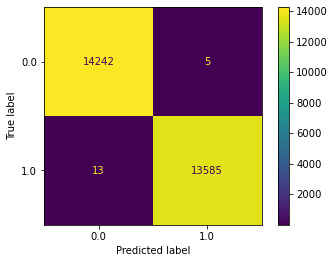

In [ ]:
# On affiche la matrice de confusion pour le jeux de test.   
accuracy = model_SVM_rbf.score(X_test, y_test) 
plot_confusion_matrix(model_SVM_rbf, X_test, y_test)  
plt.show()  

Le fait de rajouté une étape de validation croisé à fait que la valeur du score d'accuracy a diminué de prés de 1% cependant le modèle reste bon, celui-ci ne faisant que 18 erreurs d'aprés la matrice de confusion. Il est important de faire une validation croisé dans le cas des modèles avec noyaux non-linéaires car ils ont tendance à overfitter. La validation croisé est donc un outil précieu dans ce cas qui permet d'éviter ce risque. 

[0.99520028 0.99899265 0.99911116 0.95792593 0.99899259]
Accuracy:  99.00445238032533


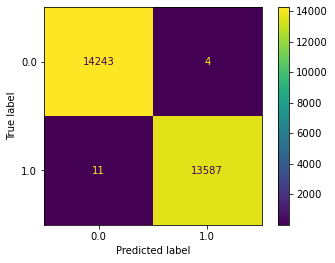

In [ ]:
#Ici on applique un Kfold de 5 sections avec un SVM C = 1
# Le modèle est très bon mais avec une accuracy légèrement infèrieur. 
kfold = KFold(n_splits=5)
model_SVM_poly = SVC(kernel = 'poly', C = 1).fit(X_train, y_train) 
result = cross_val_score(model_SVM_poly, X, y, cv=kfold)
print(result)
print("Accuracy: ", result.mean()*100)

# on affiche la matrice de confusion pour le jeu de test

accuracy = model_SVM_poly.score(X_test, y_test) 
plot_confusion_matrix(model_SVM_poly, X_test, y_test)  
plt.show()  

Non voyons que le noyau polynomial dans notre cas reste plus performant avec 15 erreurs commisent. L'accuracy a aussi diminué de prés de 1%. On peut donc considéré que l'on a réduit le risque d'overfitting, même si celui-ci était trés faible à la base.

Nous constatons que les modèles sont très long à éxécuter et ne font pas beaucoup mieux que nos modèles Ridge et LASSO optimisé précédemment. Nous allons essayer de diminuer le temps d'exécution à l'aide d'une ACP.

Faisons les test avec l'ACP.

In [ ]:
#Nous faisons une ACP avec 20 composantes.
pca = PCA(n_components = 20)
X_pca = pca.fit_transform(X) 
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[0.0970513  0.07608765 0.05870724 0.04865259 0.04367777 0.03826009
 0.03577833 0.03427951 0.02707555 0.02431742 0.02044419 0.01617463
 0.01487888 0.01381997 0.01254038 0.01150474 0.01102739 0.01034916
 0.00947076 0.0094378 ]


In [ ]:
svm = mon_SVM(X_pca, y, "rbf", C=1)

/////// SVM C=1 kernel=rbf///////
SVM rbf Train accuracy: 54.97996960906203
SVM rbf Test accuracy: 39.889216098723885
SVM rbf Average precision-recall score: 0.44
SVM rbf Confusion Matrix Train: 
[[0.56798676 0.43201324]
 [0.46845912 0.53154088]]
SVM rbf Confusion Matrix Test: 
[[0.4155579 0.5844421]
 [0.6176409 0.3823591]]
ExecTime:  171.78849880000007





In [ ]:
svm = mon_SVM(X_pca, y, "poly", C=1)

/////// SVM C=1 kernel=poly///////
SVM poly Train accuracy: 53.379265091863516
SVM poly Test accuracy: 43.13911092413406
SVM poly Average precision-recall score: 0.44
SVM poly Confusion Matrix Train: 
[[0.56498811 0.43501189]
 [0.49752587 0.50247413]]
SVM poly Confusion Matrix Test: 
[[0.45899331 0.54100669]
 [0.59599134 0.40400866]]
ExecTime:  165.52931639999997





In [ ]:
svm = mon_SVM(X_pca, y, "linear", C=1)
svm=0

/////// SVM C=1 kernel=linear///////
SVM linear Train accuracy: 50.26937422295897
SVM linear Test accuracy: 49.45309213294068
SVM linear Average precision-recall score: 0.42
SVM linear Confusion Matrix Train: 
[[0.58366939 0.41633061]
 [0.57860134 0.42139866]]
SVM linear Confusion Matrix Test: 
[[0.57648715 0.42351285]
 [0.58677282 0.41322718]]
ExecTime:  925.0810526999999





On peut voir ici qu'avec la reduction en dimension les noyaux les modèles donne de trés mauvaise prédiction et sont trés peu précis. Cela peut ce comprendre car nous avons diminuer les données afin que les nouvelles variables soient linéairement séparables avec l'ACP alors que la SVM au contraire va essayer d'augmenter la dimension de façon non linéaire, cela va complétement faussé le nouveaux jeu de variables ainsi créé par le noyau. Il faudrait utiliser une méthode de réduction des caractéristiques non-linéaires KPCA, ce que nous ne ferons pas ici.

# Ciquième Question:
* Sur la base des résultats précédents, quelle est la méthode linéaire la plus adaptée à ce problème de classification


Le modèle RIDGE est pour moi le plus performant et rapide sans optimisation. Nous expliquons cela par le fait que l'on a observé qu'avec une bonne valeur d'alpha, une pca à 20 composantes et des blocks de taille 150 on avait le meilleur ratio Accuracy/Temps d'execution.

Temps d'execution < 0.5s
Accuracy: 99%

# Dernière Question:
* Enfin, mettre en place une méthode (de votre choix) de classification multi-classe;
* Donner la matrice de confusion et indiquer les languages les plus difficile à distinguer.

Nous allons utiliser deux modèles de classification multi-classe afin de distinguer les languages les plus difficiles à distinguer. Le premier est un arbre de décision et le deuxième est une SVM avec noyau linéaire.

In [ ]:
# création du jeu de donnée à partir des 4 différentes langues

y_1 = np.full(FeaEN.shape[0], 0)
y_2 = np.full(FeaFR.shape[0], 1)
y_3 = np.full(FeaDE.shape[0], 2)
y_4 = np.full(FeaES.shape[0], 3)
X = np.concatenate((FeaEN, FeaFR, FeaDE, FeaES), axis=0)
y = np.concatenate((y_1, y_2, y_3, y_4), axis=0)

In [ ]:
# On divise le jeu de donnée en une partie d'entrainement et une partie test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [ ]:
# Entrainement du modèle d'arbre de classification de profondeur max = 2
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) # prédiction du modèle
  
# On créer la matrice de confusion 
cm = confusion_matrix(y_test, dtree_predictions) 

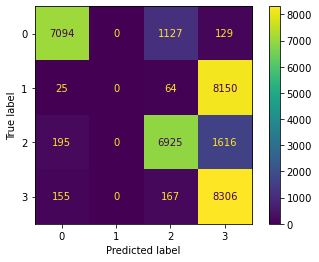

In [ ]:
# on affiche la matrice de confusion
plot_confusion_matrix(dtree_model, X_test, y_test)  
plt.show()  

On remarque d'aprés cette matrice de confusion que les languages ayant une même racine sont plus souvant confondu par le modèle. Nous remarquons aussi que le modèle a été incapable de prédire les valeurs pour le français. Tout a été faussement prédit comme étant de l'espagnol. 

Nous avons fait de même pour la classification multi-classe avec la SVM.

In [ ]:
# On entraine le modèle SVM avec noyau linéaire. 

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# calcul de l'accuracy pour le jeu de test.
accuracy = svm_model_linear.score(X_test, y_test) 
  
#On créer la matrice de confusion.
cm = confusion_matrix(y_test, svm_predictions) 

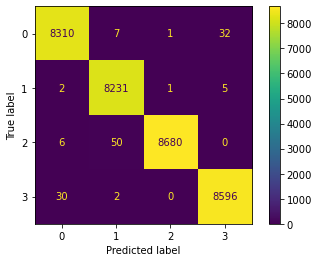

In [ ]:
plot_confusion_matrix(svm_model_linear, X_test, y_test)  
plt.show()  

Le temps d'exécution est trés long. Cependant le modèle prédit correctement chaque classes et fait trés peu d'erreurs. Nous observons que pour un problème multi-classe la SVM est à privilégier même en dépit du temps d'exécution que le modèle prend.

# Conclusion

Au cours de ce projet nous avons comparé plusieurs techniques de classifiquation appliqué sur un jeu de donnée issue de quatre langue différentes l'anglais, le français, l'allemand et l'espagnol. Nous avons utilisé les modèle Lasso, Ridge et SVM. Pour optimisé ces modèles nous avons utilisé la méthode de validation croisé afin de diminuer le risque d'overfitting et les fonctions GrirdSearch de Sklearn afin d'en déduire les meilleurs hyperparamètres. Nous avons aussi réalisé une ACP afin d'améliorer les vitesses d'exécution des différents modèles. Il en résulte que dans la cas d'une classification binaire le modèle à privilégier est le classifieur Ridge celui-ci donnant les meilleurs ratios performances/temps d'exécution. Lorsque nous avons augmenté la taille du jeu de données en diminuant la taille des blocks, le modèle Ridge est resté le modèle le plus performant. Nous avons aussi testé des modèles de SVM avec noyaux gaussien et polynomial afin de faire de la classification non-linéaire. Nous avons vu que cela n'apportait pas grand chose de plus que les modèles précédent. Enfin nous avons utilisé deux classifieur multi-classe. Nous avons vu que l'arbre de régression ne permetait pas de classer correctement chaque langue et n'arrivait pas à prédire correctement la langue française, la classant comme étant de l'espagnol. Cependant l'utilisation d'une SVM avec noyau linéaire nous a permis de classé correctement chacune de ces quatres langues avec un taux d'erreur faible.